In [1]:
# Importing packages
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import lime

import sklearn.ensemble
import sklearn.metrics

import sklearn
from sklearn.feature_extraction import text

### fetch_20newsgroups() connects to online repository to download from (~18000) newsletters on 20 different topics.

In [2]:
from sklearn.datasets import fetch_20newsgroups
# for this example, we need just two topics: alt.atheism, soc.religion.christianity
categories = ['alt.atheism', 'soc.religion.christian']

# The data is stored as already divided into subsets: 'train' and 'test'
# fetch_20newsgroups() supports fetching the data from individual subsets for specific categories

newsgroups_train = fetch_20newsgroups(
    data_home='.', subset='train', categories=categories)   # Get 'train' data rows for atheism and christianity categories
newsgroups_test = fetch_20newsgroups(
    data_home='.', subset='test', categories=categories)    # Get 'test' data rows for atheism and christianity categories

print (newsgroups_train.data[49])

From: jkellett@netcom.com (Joe Kellett)
Subject: Re: Hell
Organization: Netcom
Lines: 17

In article <Apr.10.05.33.44.1993.14422@athos.rutgers.edu> mcovingt@aisun3.ai.uga.edu (Michael Covington) writes:
>
>In a short poem ("God in His mercy made / the fixed pains of Hell"),
>C. S. Lewis expresses an idea that I'm sure was current among others,
>but I haven't be able to find its source:
>
>that even Hell is an expression of mercy, because God limits the amount
>of separation from Him, and hence the amount of agony, that one can
>achieve.
>

I have also heard it called an expression of mercy, because Heaven would be
far more agonizing for those who had rejected God.

-- 
Joe Kellett
jkellett@netcom.com



In [3]:
# Use tf-idf vectorizer, commonly used for text.
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    lowercase=True, stop_words=text.ENGLISH_STOP_WORDS)

# Learn vocab, tokenize raw text, encode and create a term-matrix for words in 'train' data
train_vectors = vectorizer.fit_transform(newsgroups_train.data) 

# tokenize raw text, encode and create a term-matrix for words in 'test' data
test_vectors = vectorizer.transform(newsgroups_test.data)       

In [5]:
# Use Random forest for training the model
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
# Provide train data and train labels (target/outcome)
rf.fit(train_vectors, newsgroups_train.target)                  

# Model is trained, make predictions on test data using the trained model.
pred = rf.predict(test_vectors)

# Compute F-score i.e., quality metric showing the accuracy level.
print ("F1 score of the RandomForest model: ", 
       sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary'))

F1 score of the RandomForest model:  0.9339622641509434


In [6]:
# Create a pipeline of vectorizer and trained model;
# The pipeline can take any sample row (newletter text) as input 
# and compute probablities of each category ('atheism', 'christianity') for the input sample
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

# Choose a random sample input 
idx = 80
print ("Test sample: \n", newsgroups_test.data[idx])

Test sample: 
 From: mayne@pipe.cs.fsu.edu (William Mayne)
Subject: Re: Christian Morality is
Organization: Florida State University Computer Science Department
Reply-To: mayne@cs.fsu.edu
Lines: 15

In article <1993Apr21.184959.9451@dcs.warwick.ac.uk> simon@dcs.warwick.ac.uk (Simon Clippingdale) writes:
>
>Dan, I'm concerned that you are in grave spiritual danger because of your
>stubborn refusal to love and accept into your heart the Mighty Invisible
>Pink Unicorn...[Nice parody deleted.]

>I shall pray for you. In fact, brother, I cast out the demon which binds you
>in the Name of the Mighty Invisible Pink Unicorn. Dan, you must have *faith*!

Then you better pray for me, too, because I believe that the Mighty
Invisibile Pink Unicorn does not exist. One being cannot be both "Pink"
and "Invisible." The demon (or should that be daemon?) that keeps me
from believing and saving my soul is named Logic.

Bill Mayne



In [7]:
test_sample_vector = vectorizer.transform([newsgroups_test.data[idx]])
test_sample_vector.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [8]:
print('For chosen sample, model prediction:[atheism = %.2f %%, christian = %.2f %%]' 
      %(c.predict_proba([newsgroups_test.data[idx]])[0,0]*100, 
        c.predict_proba([newsgroups_test.data[idx]])[0,1]*100))
print('Actual class: %s' 
      % categories[newsgroups_test.target[idx]])

For chosen sample, model prediction:[atheism = 42.80 %, christian = 57.20 %]
Actual class: alt.atheism


# Using LIME to explain/test predictions

In [9]:
from lime import lime_text
# get an explainer object
from lime.lime_text import LimeTextExplainer
import re

tokenizer = lambda doc: re.compile(r"(?u)\b\w\w+\b").findall(doc)
class_names = ['atheism', 'christian']
explainer = LimeTextExplainer(class_names=class_names,
                              split_expression=tokenizer)
# Generate an explanation for it (with at most 6 features 
# i.e., top 6 words deciding the classification) 
exp = explainer.explain_instance(newsgroups_test.data[idx],
                                 c.predict_proba, num_features=6)

# explanation is presented as a list of weighted features.
# These weighted features are a linear model,
# which approximates behaviour of the random forest classifier
# in the vicinity of the test example.
print ('LIME explanations for the sample: ')
exp.as_list()

LIME explanations for the sample: 


[('Morality', -0.11445200726633518),
 ('article', -0.06942075889234677),
 ('writes', -0.06459481295269347),
 ('faith', 0.025348844880608224),
 ('uk', -0.02532522107447205),
 ('edu', -0.02029597997781763)]

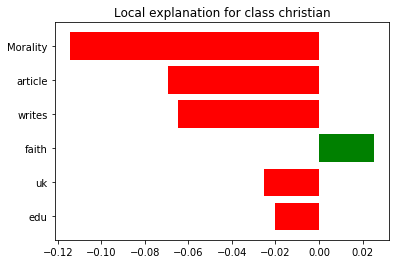

In [10]:
exp.as_pyplot_figure()
plt.show()

# The words from the newsletter Header/footer fields have also contributed to predicted category, whereas they should not !!

# Lets fix the sample text by omiting Header, footer, quote fields

In [11]:
newsgroups_train_fixed = fetch_20newsgroups (subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
newsgroups_test_fixed = fetch_20newsgroups (subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

train_vectors_fixed = vectorizer.transform (newsgroups_train_fixed.data)
test_vectors_fixed = vectorizer.transform (newsgroups_test_fixed.data)

# Use Random forest for training the model
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors_fixed, newsgroups_train_fixed.target)              

print (newsgroups_test_fixed.data [idx])



Then you better pray for me, too, because I believe that the Mighty
Invisibile Pink Unicorn does not exist. One being cannot be both "Pink"
and "Invisible." The demon (or should that be daemon?) that keeps me
from believing and saving my soul is named Logic.


In [12]:
# Model is trained, make predictions on test data using the trained model.
pred = rf.predict(test_vectors_fixed)

# Compute F-score i.e., quality metric showing the accuracy level.
print ("\nF1 score (after fixing data): ", sklearn.metrics.f1_score(newsgroups_test_fixed.target, pred, average='binary'))


F1 score (after fixing data):  0.7995169082125603


In [13]:
# After removing spurious features, predicted probabilities (atheism, christian) by trained model
print("After removing fields, probabilities: ['aethism': %.2f %%, 'christianity': %.2f %%]" 
      %(rf.predict_proba(test_vectors_fixed[idx])[0,0]*100,
        rf.predict_proba(test_vectors_fixed[idx])[0,1]*100))

After removing fields, probabilities: ['aethism': 58.90 %, 'christianity': 41.10 %]


In [14]:
exp = explainer.explain_instance(newsgroups_test_fixed.data[idx],
                                 c.predict_proba, num_features=6)
# After removing spurious features, LIME explanations
exp.as_list()

[('believing', -0.04265524820492573),
 ('Pink', -0.034019564581358804),
 ('exist', -0.013316131761118953),
 ('Unicorn', -0.010135706050253063),
 ('better', -0.009716611208749575),
 ('keeps', -0.008014986785662889)]

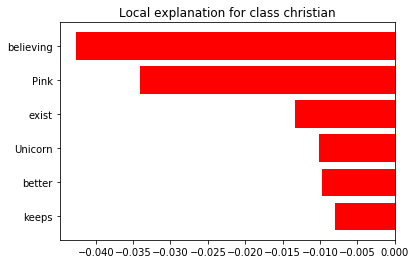

In [15]:
exp.as_pyplot_figure()
plt.show()